In [ ]:
Stage 3 training on 229*229

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Project/COVID-19-master

/content/drive/.shortcut-targets-by-id/148tduUm3_N2YmcWCKycU5qdfNmgLJccA/Project/COVID-19-master


In [4]:
# #importing 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [5]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

In [6]:
from os import listdir
from os.path import isfile, join
xtrain_229=np.load('data/x_train_229.npy')
ytrain = np.load('data/y_train.npy')
print("RUN HOGAYA")
    
xtest = np.load('data/x_test.npy')
ytest = np.load('data/y_test.npy')

RUN HOGAYA


229 wala

In [7]:
def confusion_matrix_info(y_true, y_pred, labels=['normal', 'pneumonia',  'COVID-19'],
                          title='confusion matrix'):
    import seaborn as sns
    import pandas as pd
    from sklearn.metrics import confusion_matrix, f1_score
    import matplotlib.pyplot as plt
    C2 = confusion_matrix(y_true, y_pred)
    C = pd.DataFrame(C2, columns=labels, index=labels)
    m, _ = C2.shape
    for i in range(m):
        precision = C2[i, i] / sum(C2[:, i])
        recall = C2[i, i] / sum(C2[i, :])
        f1 = 2 * precision * recall / (precision + recall)
        print('In class {}:\t total samples: {}\t true predict samples: {}\t'
              'acc={:.4f},\trecall={:.4f},\tf1-score={:.4f}'.format(
            labels[i], sum(C2[i, :]), C2[i, i], precision, recall, f1))
    print('-' * 100, '\n', 'average f1={:.4f}'.format(f1_score(y_true, y_pred, average='micro')))
 
    f, ax = plt.subplots()
    sns.heatmap(C, annot=True, ax=ax, cmap=plt.cm.binary)
    ax.set_title(title)
    ax.set_xlabel('predict')
    ax.set_ylabel('true')
    plt.savefig(title+'.jpg')

In [10]:

resnet_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
NUM_CLASSES = 3
DENSE_LAYER_ACTIVATION = 'softmax'



In [17]:
#resnet_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
NUM_CLASSES = 3
DENSE_LAYER_ACTIVATION = 'softmax'



def Third_keras_model():
    model3 = Sequential()

    # 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
    # NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
    model3.add(ResNet50(include_top = False,input_shape=(229,229,3), pooling = 'avg',weights = resnet_weights_path))
    model3.add(BatchNormalization())

    # 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
    model3.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
    model3.load_weights("model2.h5")

    # Say not to train first layer (ResNet) model as it is already trained
    
    return model3

In [19]:
def train(xtrain229, y,x_test,y_test):
    y = tf.keras.utils.to_categorical(y, 3)
    y_test = tf.keras.utils.to_categorical(y_test, 3)


    #TRAINING ON 229*229 WITH FREEZED RESNET LAYER
    model3 = Third_keras_model()
    model3=model3
    model3.layers[0].trainable = False
    print(model3.summary())
    opt=tf.keras.optimizers.Adam(lr=0.00001)
    model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    hist = model3.fit(xtrain229, y, batch_size=32, validation_data=(x_test, y_test), epochs=25, verbose=1)
    model3.save('Final_model.h5')
    y_pred = model3.predict(xtrain229)
    confusion_matrix_info(np.argmax(y, axis=1), np.argmax(y_pred, axis=1),title='confusion_matrix_train')

In [26]:
def test(xt, yt):
    model = tf.keras.models.load_model('Final_model.h5')
    
    y_pred = model.predict(xt)
    confusion_matrix_info(yt, np.argmax(y_pred, axis=1),title='confusion_matrix_test')

In [ ]:
train(xtrain_229, ytrain,xtest,ytest)

In class normal:	 total samples: 100	 true predict samples: 92	acc=0.8679,	recall=0.9200,	f1-score=0.8932
In class pneumonia:	 total samples: 100	 true predict samples: 93	acc=0.7500,	recall=0.9300,	f1-score=0.8304
In class COVID-19:	 total samples: 100	 true predict samples: 70	acc=1.0000,	recall=0.7000,	f1-score=0.8235
---------------------------------------------------------------------------------------------------- 
 average f1=0.8500


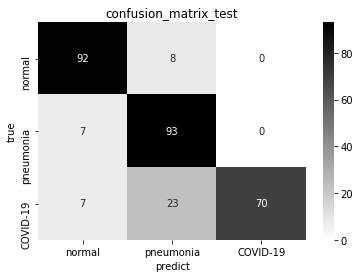

In [24]:
test(xtest, ytest)

In class normal:	 total samples: 7966	 true predict samples: 7852	acc=0.9754,	recall=0.9857,	f1-score=0.9805
In class pneumonia:	 total samples: 5475	 true predict samples: 5272	acc=0.9768,	recall=0.9629,	f1-score=0.9698
In class COVID-19:	 total samples: 517	 true predict samples: 497	acc=0.9726,	recall=0.9613,	f1-score=0.9669
---------------------------------------------------------------------------------------------------- 
 average f1=0.9759


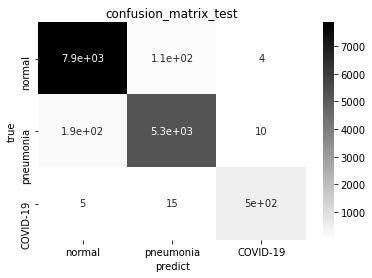

In [27]:
test(xtrain_229, ytrain)